In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import os

In [3]:
base_dir = 'data'

image_height = 224
image_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    featurewise_std_normalization=True, # Normalize images
    samplewise_std_normalization=True
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    rotation_range=40,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True
)

C:\Users\Santosh Simhadri\AppData\Roaming\Python\Python310\site-packages\keras\src\preprocessing\image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(
C:\Users\Santosh Simhadri\AppData\Roaming\Python\Python310\site-packages\keras\src\preprocessing\image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


In [4]:
batch_size=32

train_data_path =  base_dir + '/train'
valid_data_path = base_dir + '/validation'
test_data_path =  base_dir + '/test'

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    test_data_path,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    valid_data_path,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical'
)
class_names = list(train_generator.class_indices.keys())

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


In [5]:
import json
with open(base_dir+'/cat_to_name.json', 'r') as json_file:
    cat_2_name = json.load(json_file)
cat_2_name['211']


'1 Dollar,US Dollar,usa'

C:\Users\Santosh Simhadri\AppData\Roaming\Python\Python310\site-packages\keras\src\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
C:\Users\Santosh Simhadri\AppData\Roaming\Python\Python310\site-packages\keras\src\preprocessing\image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or

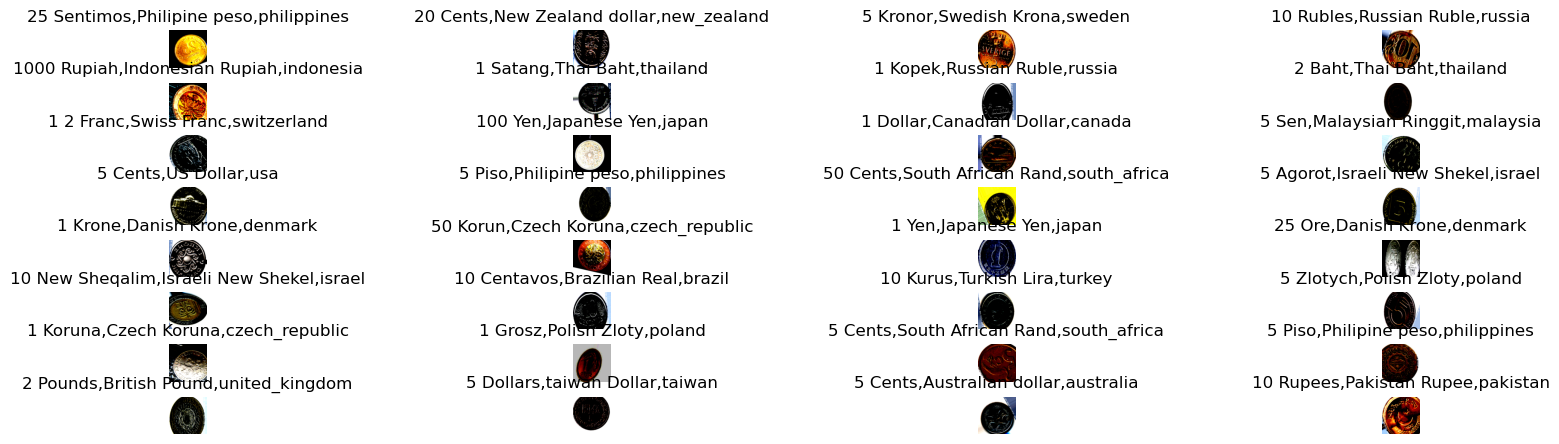

In [6]:
import matplotlib.pyplot as plt

images,label = train_generator.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
   
for i in range(batch_size):
    ax = plt.subplot(15,4,i+1)
    plt.imshow(images[i])
    plt.title(cat_2_name[class_names[label[i].argmax()]])
    plt.axis("off")


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


num_classes=211
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,  
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/15
200/200 [==============================] - 252s 1s/step - loss: 4.0548 - accuracy: 0.2109 - val_loss: 2.9754 - val_accuracy: 0.3654
Epoch 2/15
200/200 [==============================] - 168s 837ms/step - loss: 2.2094 - accuracy: 0.5063 - val_loss: 2.3047 - val_accuracy: 0.5108
Epoch 3/15
200/200 [==============================] - 163s 813ms/step - loss: 1.6155 - accuracy: 0.6206 - val_loss: 1.9601 - val_accuracy: 0.5697
Epoch 4/15
200/200 [==============================] - 170s 850ms/step - loss: 1.3038 - accuracy: 0.6819 - val_loss: 1.7780 - val_accuracy: 0.6070
Epoch 5/15
200/200 [==============================] - 167s 836ms/step - loss: 1.0797 - accuracy: 0.7270 - val_loss: 1.7221 - val_accuracy: 0.6202
Epoch 6/15
200/200 [==============================] - 181s 904ms/step - loss: 0.9376 - accuracy: 0.7532 - val_loss: 1.7086 - val_accuracy: 0.6322
Epoch 7/15
200/200 [==============================] - 163s 811ms/step - loss: 0.8009 - accuracy: 0.7945 - val_loss: 1.5698 - va

In [9]:
num_test = test_generator.samples
score = model.evaluate_generator(test_generator, steps=num_test // batch_size, verbose=1)
print('\n', 'Test accuracy:', score[1])

C:\Users\Santosh Simhadri\AppData\Local\Temp\ipykernel_13824\1870478819.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator, steps=num_test // batch_size, verbose=1)


26/26 [==============================] - 27s 1s/step - loss: 1.4484 - accuracy: 0.6959

 Test accuracy: 0.6959134340286255


In [10]:
model_version=2
model.save(f"Models/Model{model_version}")

INFO:tensorflow:Assets written to: Models/Model2\assets


INFO:tensorflow:Assets written to: Models/Model2\assets


In [11]:
int_to_dir = {v: k for k, v in train_generator.class_indices.items()}
print(int_to_dir)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '103', 6: '104', 7: '105', 8: '106', 9: '107', 10: '108', 11: '109', 12: '11', 13: '110', 14: '111', 15: '112', 16: '113', 17: '114', 18: '115', 19: '116', 20: '117', 21: '118', 22: '119', 23: '12', 24: '120', 25: '121', 26: '122', 27: '123', 28: '124', 29: '125', 30: '126', 31: '127', 32: '128', 33: '129', 34: '13', 35: '130', 36: '131', 37: '132', 38: '133', 39: '134', 40: '135', 41: '136', 42: '137', 43: '138', 44: '139', 45: '14', 46: '140', 47: '141', 48: '142', 49: '143', 50: '144', 51: '145', 52: '146', 53: '147', 54: '148', 55: '149', 56: '15', 57: '150', 58: '151', 59: '152', 60: '153', 61: '154', 62: '155', 63: '156', 64: '157', 65: '158', 66: '159', 67: '16', 68: '160', 69: '161', 70: '162', 71: '163', 72: '164', 73: '165', 74: '166', 75: '167', 76: '168', 77: '169', 78: '17', 79: '170', 80: '171', 81: '172', 82: '173', 83: '174', 84: '175', 85: '176', 86: '177', 87: '178', 88: '179', 89: '18', 90: '180', 91: '181', 92: '182

In [35]:
import pandas as pd
df = pd.DataFrame({'Column_Name': int_to_dir})
df.to_csv('int_to_dir.csv')

In [36]:
from tensorflow.keras.preprocessing import image
def get_prediction(img_path,real_label):
    # Preprocess the image directly without using img_to_array

    # Load and preprocess the image using the appropriate preprocessing functions
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)  # Convert PIL image to array

    # Normalize the image
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = (img / 255.0 - mean) / std

    img_expand = np.expand_dims(img, axis=0)

    prediction = model.predict(img_expand)
    prediction_int = np.argmax(prediction)

    dir_int = int_to_dir[prediction_int]
    label_name = cat_2_name[str(dir_int)]
    print("Predicted class: ",cat_2_name[str(dir_int)])
    print("Actual class: ",cat_2_name[str(real_label)])

In [37]:
for i in range(15):
    random_index = np.random.randint(0, len(test_generator.filenames))
    img = test_generator.filenames[random_index]
    img_path = test_data_path+"/" + img
    real_label = test_generator.filenames[random_index].split("\\")[0]
    

    get_prediction(img_path, real_label)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 46ms/step


<IPython.core.display.Javascript object>

Predicted class:  50 Pence,British Pound,united_kingdom
Actual class:  50 Pence,British Pound,united_kingdom


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 29ms/step


<IPython.core.display.Javascript object>

Predicted class:  1 Sentimo,Philipine peso,philippines
Actual class:  5 Sentimos,Philipine peso,philippines


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 49ms/step


<IPython.core.display.Javascript object>

Predicted class:  1 Rand,South African Rand,south_africa
Actual class:  1 Rand,South African Rand,south_africa


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 30ms/step


<IPython.core.display.Javascript object>

Predicted class:  10 Ore,Swedish Krona,sweden
Actual class:  10 Ore,Swedish Krona,sweden


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 32ms/step


<IPython.core.display.Javascript object>

Predicted class:  10 Cents,New Zealand dollar,new_zealand
Actual class:  5 Cents,Australian dollar,australia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 47ms/step


<IPython.core.display.Javascript object>

Predicted class:  10 Sentimos,Philipine peso,philippines
Actual class:  10 Sentimos,Philipine peso,philippines


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 25ms/step


<IPython.core.display.Javascript object>

Predicted class:  1 Yen,Japanese Yen,japan
Actual class:  1 Yen,Japanese Yen,japan


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 27ms/step


<IPython.core.display.Javascript object>

Predicted class:  1 Peso,Mexican peso,mexico
Actual class:  5 Cents,Australian dollar,australia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 40ms/step


<IPython.core.display.Javascript object>

Predicted class:  10 Cents,Singapore Dollar,singapore
Actual class:  10 Cents,Singapore Dollar,singapore


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 41ms/step


<IPython.core.display.Javascript object>

Predicted class:  2 Cents,Australian dollar,australia
Actual class:  2 Cents,Australian dollar,australia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 41ms/step


<IPython.core.display.Javascript object>

Predicted class:  5 euro Cent,Euro,spain
Actual class:  1 euro Cent,Euro,spain


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 42ms/step


<IPython.core.display.Javascript object>

Predicted class:  5 Pesos,Mexican peso,mexico
Actual class:  5 Pesos,Mexican peso,mexico


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 53ms/step


<IPython.core.display.Javascript object>

Predicted class:  10 Kroner,Norwegian Krone,norway
Actual class:  10 Kroner,Norwegian Krone,norway


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 48ms/step


<IPython.core.display.Javascript object>

Predicted class:  5 Sen,Malaysian Ringgit,malaysia
Actual class:  10 Sen,Malaysian Ringgit,malaysia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 47ms/step


<IPython.core.display.Javascript object>

Predicted class:  10 Hellers,Czech Koruna,czech_republic
Actual class:  10 Hellers,Czech Koruna,czech_republic


In [40]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

num_classes = 211

# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False)

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,  
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/15
200/200 [==============================] - 713s 4s/step - loss: 4.9971 - accuracy: 0.0672 - val_loss: 4.5198 - val_accuracy: 0.0986
Epoch 2/15
200/200 [==============================] - 699s 3s/step - loss: 3.7399 - accuracy: 0.2384 - val_loss: 3.4891 - val_accuracy: 0.3029
Epoch 3/15
200/200 [==============================] - 696s 3s/step - loss: 2.8837 - accuracy: 0.3887 - val_loss: 2.9931 - val_accuracy: 0.3654
Epoch 4/15
200/200 [==============================] - 713s 4s/step - loss: 2.4057 - accuracy: 0.4828 - val_loss: 2.6342 - val_accuracy: 0.4351
Epoch 5/15
200/200 [==============================] - 727s 4s/step - loss: 2.0745 - accuracy: 0.5479 - val_loss: 2.3824 - val_accuracy: 0.4892
Epoch 6/15
200/200 [==============================] - 720s 4s/step - loss: 1.8353 - accuracy: 0.5987 - val_loss: 2.1902 - val_accuracy: 0.5312
Epoch 7/15
200/200 [==============================] - 725s 4s/step - loss: 1.6638 - accuracy: 0.6345 - val_loss: 2.0909 - val_accuracy: 0.5757

In [43]:
model_version='_VGG16'
model.save(f"Models/Model{model_version}")

INFO:tensorflow:Assets written to: Models/Model_VGG16\assets


INFO:tensorflow:Assets written to: Models/Model_VGG16\assets
